# `flarestack` Test Minimization Notebook

## 1. Directory Setup

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'fit_weights_hmc': flarestack.core.minimisation.FitWeightHMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity

Let's try to calculate the 10-year point source sensitivity for our test catalogue.  
The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
First we have to specify a name for the analysis.

In [7]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
from glob import glob

In [8]:
# min_types = ('fixed', 'fit', 'mcmc', 'hmc')

# def name_func(n_sources, gamma, min_type):
#     run_no = 1
#     if min_type in min_types:
#         path = f'analyses/{n_sources}source_gamma_{gamma}_{min_type}_run{run_no}'
#         path_exist = True
#         while path_exist is True:
#             try:
#                 if os.path.exists(plot_output_dir(path)) or os.path.exists(name_pickle_output_dir(path)):
#                     path_exist = True
#                     path = path.replace(f'run{run_no}', f'run{run_no + 1}')
#                     run_no += 1
#                 else:
#                     path_exist = False
#             except:
#                 pass
#         return path
#     else:
#         print('Provide valid minimizer: ', colored(186,33,33, min_types))

In [9]:
min_types = ('fixed', 'fit', 'mcmc', 'hmc')

def name_func(n_sources, gamma, min_type, etc=None):
    """Creates name for output analysis files.
    
    :param n_sources: Number of sources in catalog
    :type n_sources: int
    
    :param gamma: Spectral index
    :type n_sources: float
    
    :param min_type: Minimization method (see MinimisationHandler.subclasses)
    :type n_sources: str
    
    :param etc: Additional simulation/run info
    :type n_sources: str
    
    :return path: Path used as name
    :rtype path: str
    """
    run_no = 1
    
    if min_type not in min_types:
        raise ValueError(f'Provide valid minimizer: {min_types}')
        
    path = f'analyses/{n_sources}source_gamma_{gamma}_{min_type}'
    
    if etc is not None:
        path += f'_{etc:s}'
        
    path += f'_run{run_no}'
    
    path_exist = os.path.exists(plot_output_dir(path)) or os.path.exists(name_pickle_output_dir(path))
    
    if path_exist:
        # Automatically covers cases where run_no == (n_sources or gamma)
        glob_path = path.split(f'_run{run_no}')[0]
        # Get all runs with same path
        previous_runs = glob(f'{name_pickle_output_dir(glob_path)}*')
        # Get run numbers for previous runs, convert strings to ints
        run_nums = [int(i.split('run')[1]) for i in previous_runs]
        # Sort run numbers
        run_nums.sort()
        # Get last run number, increase index by 1
        run_no = run_nums[-1] + 1
        path = f'{glob_path}_run{run_no}'
    else:
        # Path DNE, unchanged path (run 1)
        pass
    
    return path

In [10]:
name = name_func(n_sources=2, gamma=2.0, min_type='mcmc', etc='largecatalog')
name

'analyses/2source_gamma_2.0_mcmc_largecatalog_run1'

Our plot output directories will be:

In [11]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
plot_output_dir(name), name_pickle_output_dir(name)

('/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_largecatalog_run1',
 '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma_2.0_mcmc_largecatalog_run1')

Many dataset implementations are available in `flarestack.data`. We will use the PS Tracks v3.2

In [12]:
# from flarestack.data.icecube import ps_v003_p02
from flarestack.data.public import icecube_ps_3_year

We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [13]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0
}

injection_time = {
    "time_pdf_name": "steady"
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [14]:
llh_time = {
    "time_pdf_name": "steady"
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [15]:
# from flarestack.utils.prepare_catalogue import ps_catalogue_name
import numpy as np

sindec = 0.5
catalogue_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_20.npy"
print(f'your catalogue is located at {catalogue_path}')
catalogue = np.load(catalogue_path)
catalogue

your catalogue is located at /Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_20.npy


array([(0.19872028, -2.48868437e-01, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il'),
       (3.67889954, -6.71520278e-01, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab'),
       (4.07351703, -1.36351812e+00, 1., 1., nan, nan, nan, 8.37090064e+12, b'ASASSN-15hs'),
       (2.88886971,  6.11015530e-02, 1., 1., nan, nan, nan, 3.26425608e+13, b'ASASSN-15ik'),
       (1.23868053, -1.69325057e-01, 1., 1., nan, nan, nan, 2.42313661e+13, b'ASASSN-15nx'),
       (2.65346479,  3.36839819e-01, 1., 1., nan, nan, nan, 3.14644460e+13, b'ASASSN-15rb'),
       (6.14176782,  5.13260124e-01, 1., 1., nan, nan, nan, 1.48012254e+13, b'ASASSN-15tm,PS15dqg'),
       (3.55570765,  1.91727812e-01, 1., 1., nan, nan, nan, 5.82990321e+13, b'ASASSN-15ua,CSS160204:133454+1'),
       (0.33592788, -8.62512628e-02, 1., 1., nan, nan, nan, 3.57271144e+13, b'ASASSN-15uo,AT2016dqg,Gaia16ac'),
       (2.91397263,  3.31510747e-01, 1., 1., nan, nan, nan, 1.85568464e+13, b'0'),
       (3.05887714,  1.13522663e+0

Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$.

In [16]:
from flarestack.shared import flux_to_k
flux_to_k(1)

999999999.9999999

Here we know where the sensitivity should be. Because the analysis has been done before.

In [17]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalogue['dec_rad']))) * 3
scale

array([ 6.24859081, 24.92108471, 27.77154076,  1.27010269,  4.2832197 ,
        1.69532674,  1.73886197,  1.4678642 ,  1.8077471 ,  1.66935642,
        3.23676414,  1.66784302,  2.06959601,  1.89938563,  1.19075127,
        1.23934347,  1.20576703,  1.17015605,  1.18177876,  1.23505297])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`

In [18]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights_mcmc",                          # name of the MinimisationHandler subcalss
    "dataset": icecube_ps_3_year.get_seasons("IC86-2012"),  # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": 1000,                                          # a guess for the sensitivity scale
    "n_trials": 10,                                         # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [19]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=10,                                # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/2source_gamma_2.0_mcmc_largecatalog_run1 -----
not using cluster 
using 10 CPUs locally
job-id: None 
no scale estimation 



Energise ......

In [20]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86-2012
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:Added 190 trials to queue. Now processing.
INFO:flarestack.core.multiprocess_wrapper:190 tasks remaining.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
/Users/thomasahrens/Desktop/IceCube/flarestack/flarestack/core/llh.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple

INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:175 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:174 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:173 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:173 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:173 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:171 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:171 tasks rem

INFO:flarestack.core.multiprocess_wrapper:139 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:139 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:137 tasks rem

INFO:flarestack.core.multiprocess_wrapper:115 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:114 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:113 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:113 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:112 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:111 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:111 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:111 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:111 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:111 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:110 tasks rem

INFO:flarestack.core.multiprocess_wrapper:89 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:88 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:87 tasks remaining.
INFO:fla

INFO:flarestack.core.multiprocess_wrapper:66 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:66 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:66 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:65 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:65 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:65 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:65 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:65 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:64 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:64 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:64 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:64 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:64 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:63 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:63 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:63 tasks remaining.
INFO:fla

INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:42 tasks remaining.
INFO:fla

INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:15 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:14 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:14 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:14 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:14 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:13 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:13 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:13 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:12 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:12 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:12 tasks remaining.
INFO:fla

To get the results we use the `ResultsHandler()`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory. If `OverfluctuationError`, set `do_sens=False` and `do_disc=False` in `ResultsHandler()` object.

In [21]:
from flarestack.core.results import ResultsHandler
results_handler = ResultsHandler(submitter.mh_dict, do_sens=False, do_disc=False)
# results_handler.__dict__

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_largecatalog_run1/bias_n_s (b'ASASSN-15hs').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_largecatalog_run1/bias_n_s (b'ASASSN-15tm,PS15dqg').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_largecatalog_run1/bias_n_s (b'ASASSN-15ab').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_largecatalog_run1/bias_n_s (b'0').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2so

In [22]:
# print(fr'sensitivity flux: {results_handler.sensitivity:.2e} +{results_handler.sensitivity_err[1]}  -{results_handler.sensitivity_err[0]}')
# print(f'reference: {reference_sensitivity(sindec)[0]}')
# print(fr'sensitivity n_s: {results_handler.sensitivity * results_handler.flux_to_ns:.2e} +{results_handler.sensitivity_err[1] * results_handler.flux_to_ns}  -{results_handler.sensitivity_err[0] * results_handler.flux_to_ns}')

## 4. MCMC Analysis Plots

### Corner Plot

In [23]:
import pickle
import corner
import matplotlib.pyplot as plt

In [24]:
# Path to MCMC pickle directory
# mcmc_pickle_path = '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/10source_gamma_2.0_mcmc_run1/chains.pkl'
mcmc_pickle_path = os.path.join(name_pickle_output_dir(name), 'chains.pkl')

with open(mcmc_pickle_path, 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle.shape

(10000, 50, 21)

In [25]:
# Number of dimensions
ndim = len(catalogue) + 1

# Reshape MCMC chains
mcmc_chains = mcmc_pickle[:,...].reshape((-1,ndim))

mcmc_chains.shape

(500000, 21)

In [26]:
# Get source names for labels
labels = []

for source in range(len(catalogue)):
    label = catalogue[source]['source_name'].decode()
    labels.append('n_s: ' + label)

labels.append('gamma')

corner_labels = [x for x in labels]
corner_labels

['n_s: ASASSN-14il',
 'n_s: ASASSN-15ab',
 'n_s: ASASSN-15hs',
 'n_s: ASASSN-15ik',
 'n_s: ASASSN-15nx',
 'n_s: ASASSN-15rb',
 'n_s: ASASSN-15tm,PS15dqg',
 'n_s: ASASSN-15ua,CSS160204:133454+1',
 'n_s: ASASSN-15uo,AT2016dqg,Gaia16ac',
 'n_s: 0',
 'n_s: Gaia15ada,PS15ye',
 'n_s: PS15asc',
 'n_s: PS15cyi,MASTER OT J080005.70+3',
 'n_s: PS15ou,SNHiTS15by',
 'n_s: SDSS-II SN 11241',
 'n_s: SDSS-II SN 11927',
 'n_s: SDSS-II SN 13482',
 'n_s: SDSS-II SN 14532',
 'n_s: SDSS-II SN 14661',
 'n_s: SDSS-II SN 15367',
 'gamma']

In [27]:
# Get truth values
truths = np.append(scale, injection_energy['gamma'])
truths

array([ 6.24859081, 24.92108471, 27.77154076,  1.27010269,  4.2832197 ,
        1.69532674,  1.73886197,  1.4678642 ,  1.8077471 ,  1.66935642,
        3.23676414,  1.66784302,  2.06959601,  1.89938563,  1.19075127,
        1.23934347,  1.20576703,  1.17015605,  1.18177876,  1.23505297,
        2.        ])

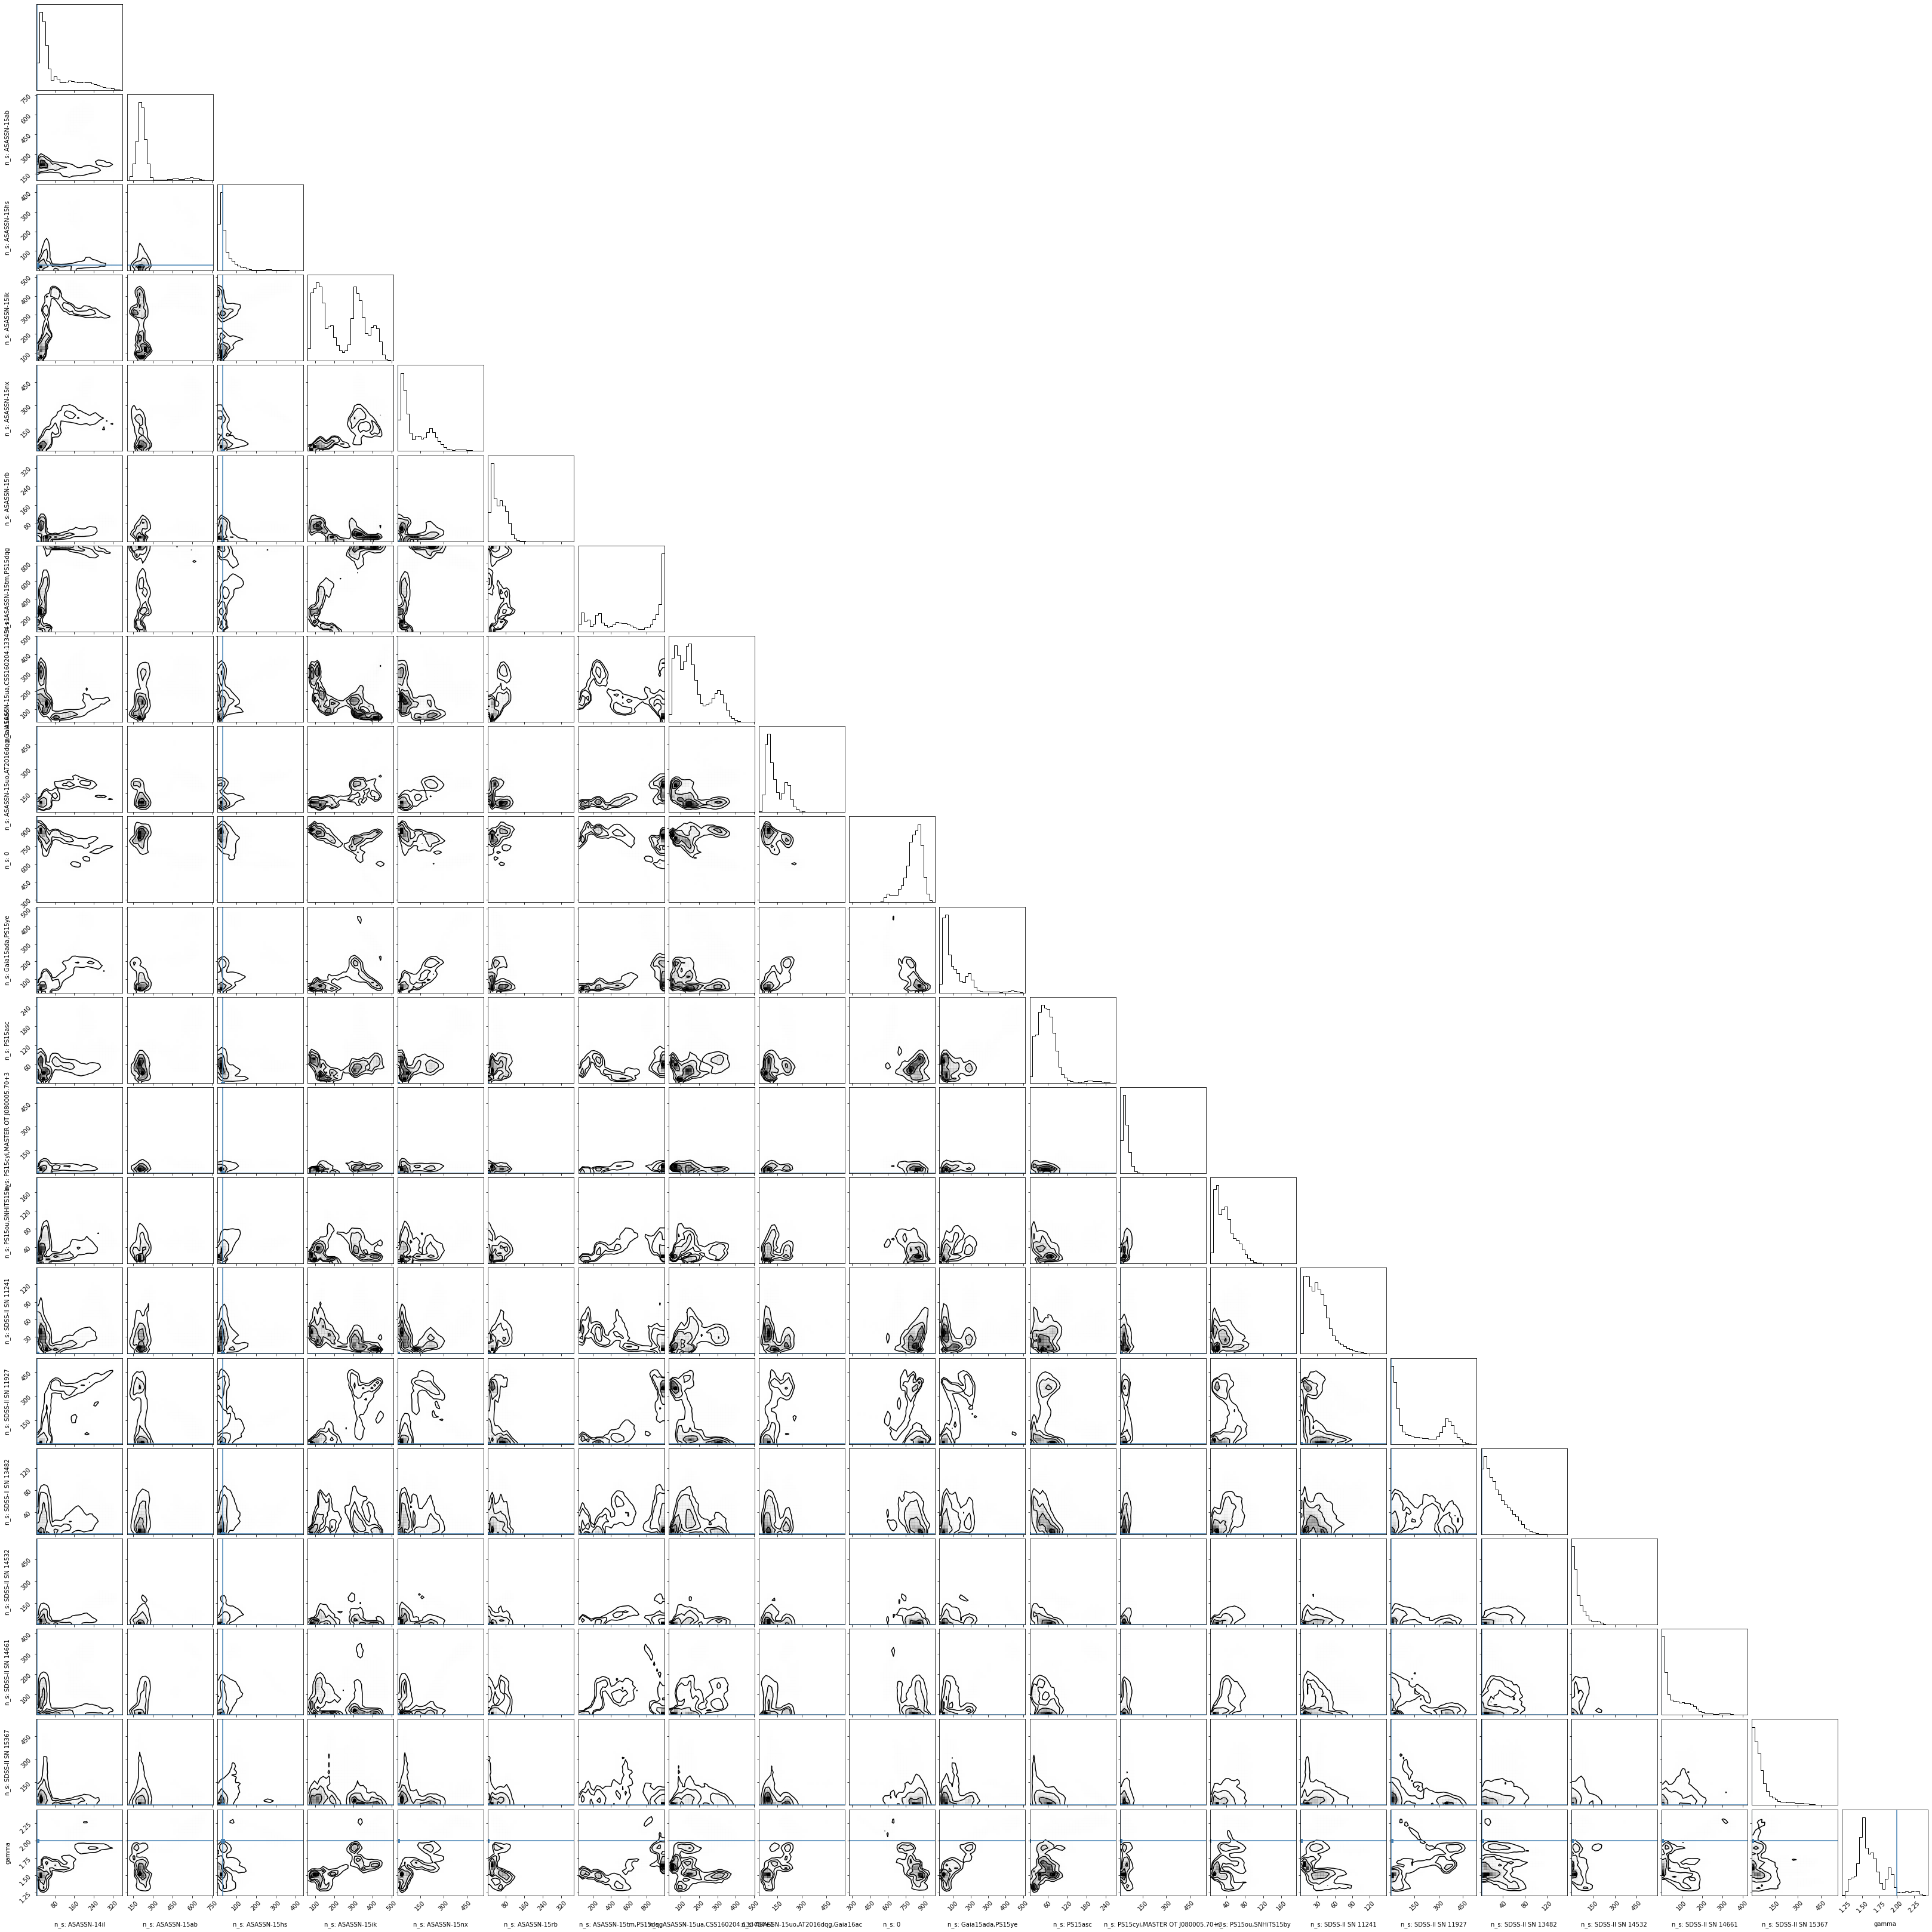

In [28]:
# Corner plot with burn in
fig = corner.corner(mcmc_chains,
                    labels=corner_labels,
#                     levels=[1-np.exp(-0.5*(x**2)) for x in range(1,4)],
#                     range=[[1100,1350], [50,200], [-20,20], [0.4,0.9], [1.7*np.pi,2*np.pi], [0.12,0.32], [0.5,1.5]],
                    truths = truths,
                    plot_datapoints=False,
                    bins=30)

### Walker Steps

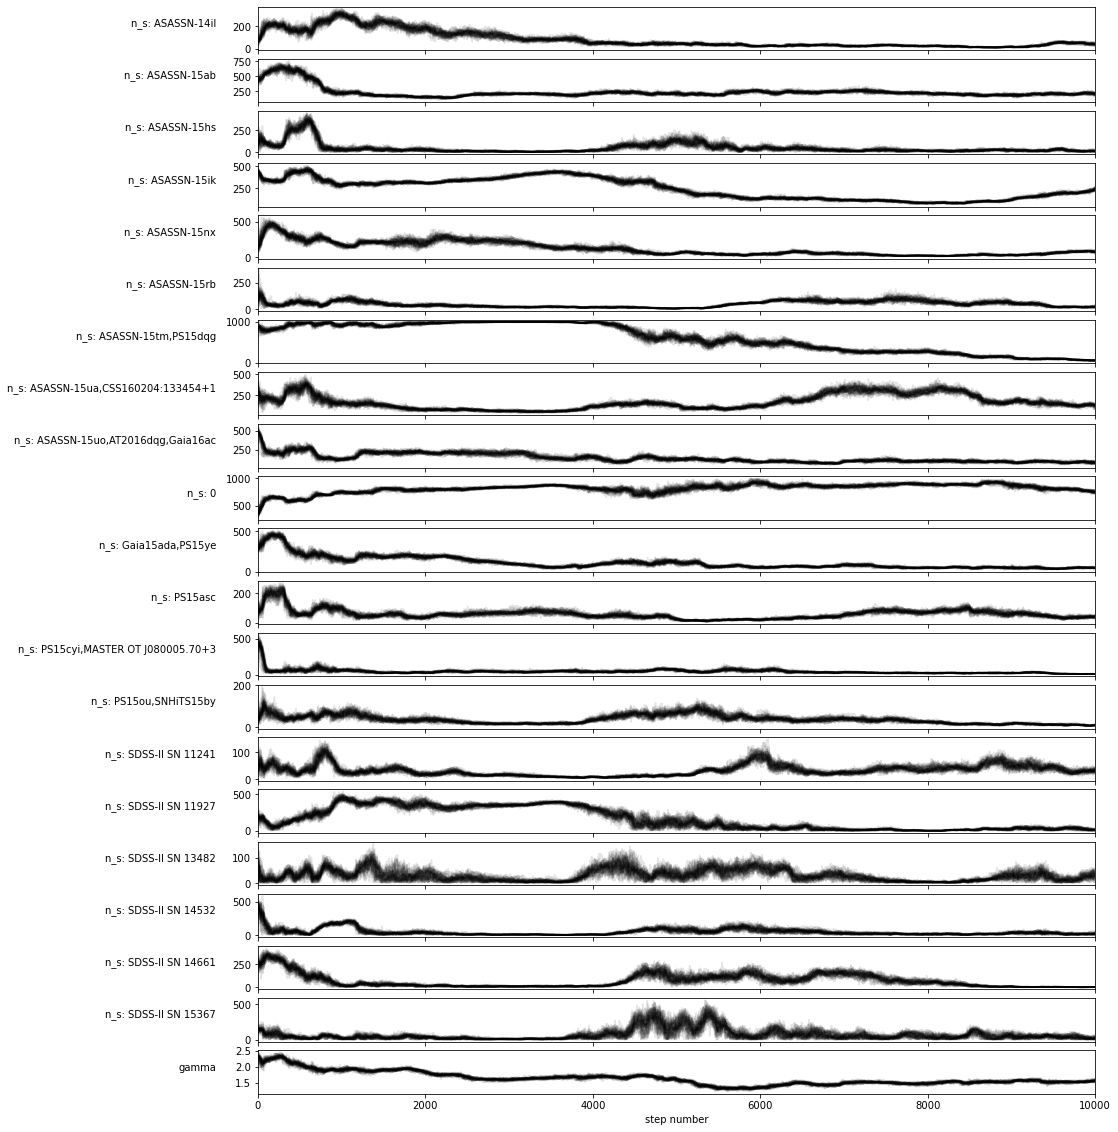

In [41]:
fig, axes = plt.subplots(ndim, figsize=(15, 20), sharex=True)
# samples = sampler.get_chain()
labels= corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
fig.tight_layout

# Save figure to output directory
plt.savefig(os.path.join(plot_output_dir(name), 'walkers.png'))

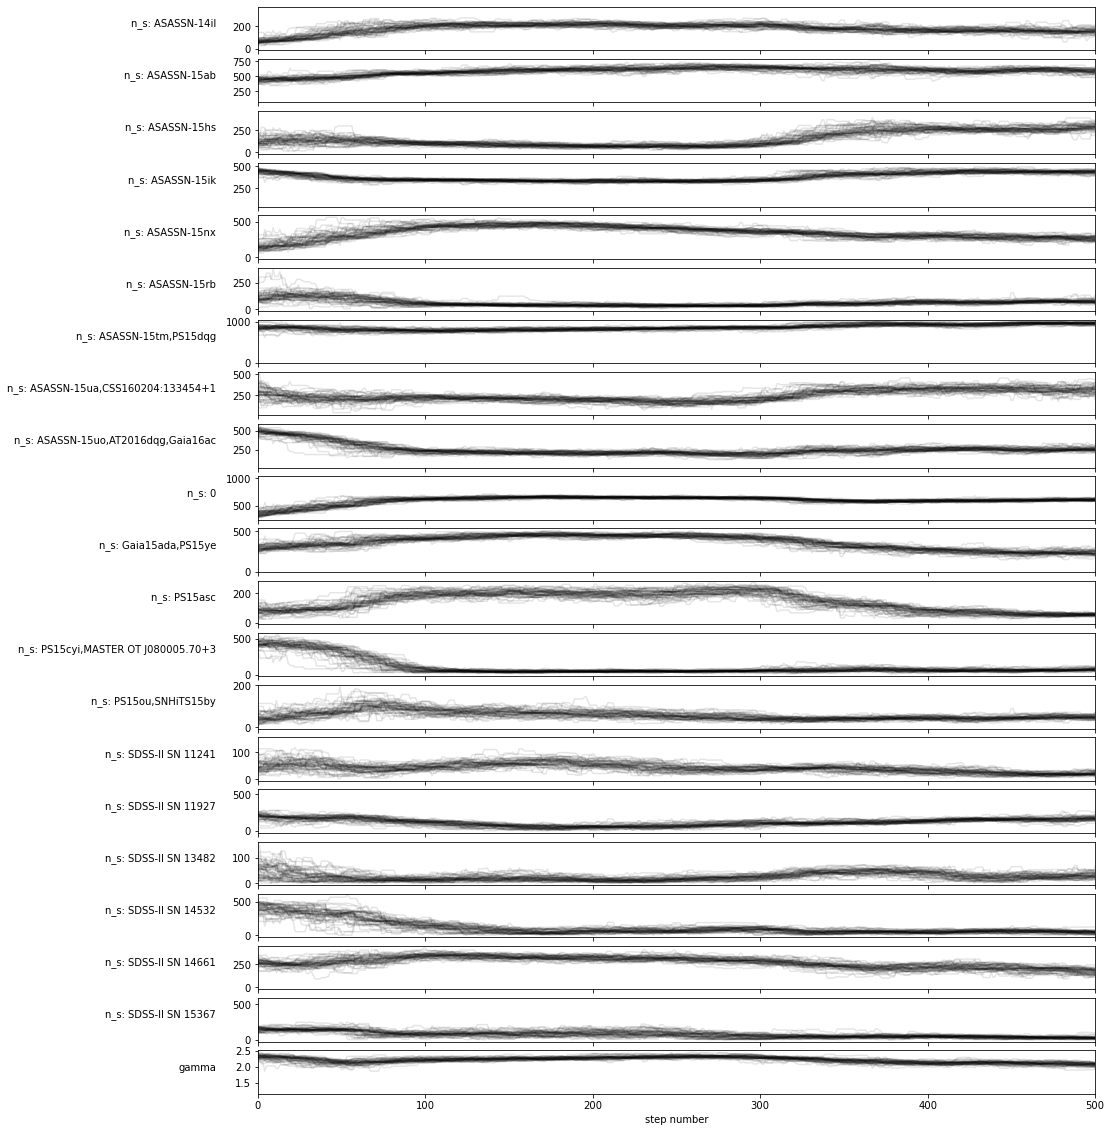

In [42]:
# First 500 steps
fig, axes = plt.subplots(ndim, figsize=(15, 20), sharex=True)
# samples = sampler.get_chain()
labels =  corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(mcmc_pickle[:500]))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number")
fig.tight_layout;

### Autocorrelation Function

In [31]:
import emcee.autocorr as eac

In [32]:
eac.function_1d(mcmc_pickle[:,0,2])

array([ 1.00000000e+00,  9.98035779e-01,  9.96269166e-01, ...,
       -9.23939494e-05, -6.15959663e-05, -3.07979831e-05])

N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]
N/50 = 200;
tau: [953.87132976]


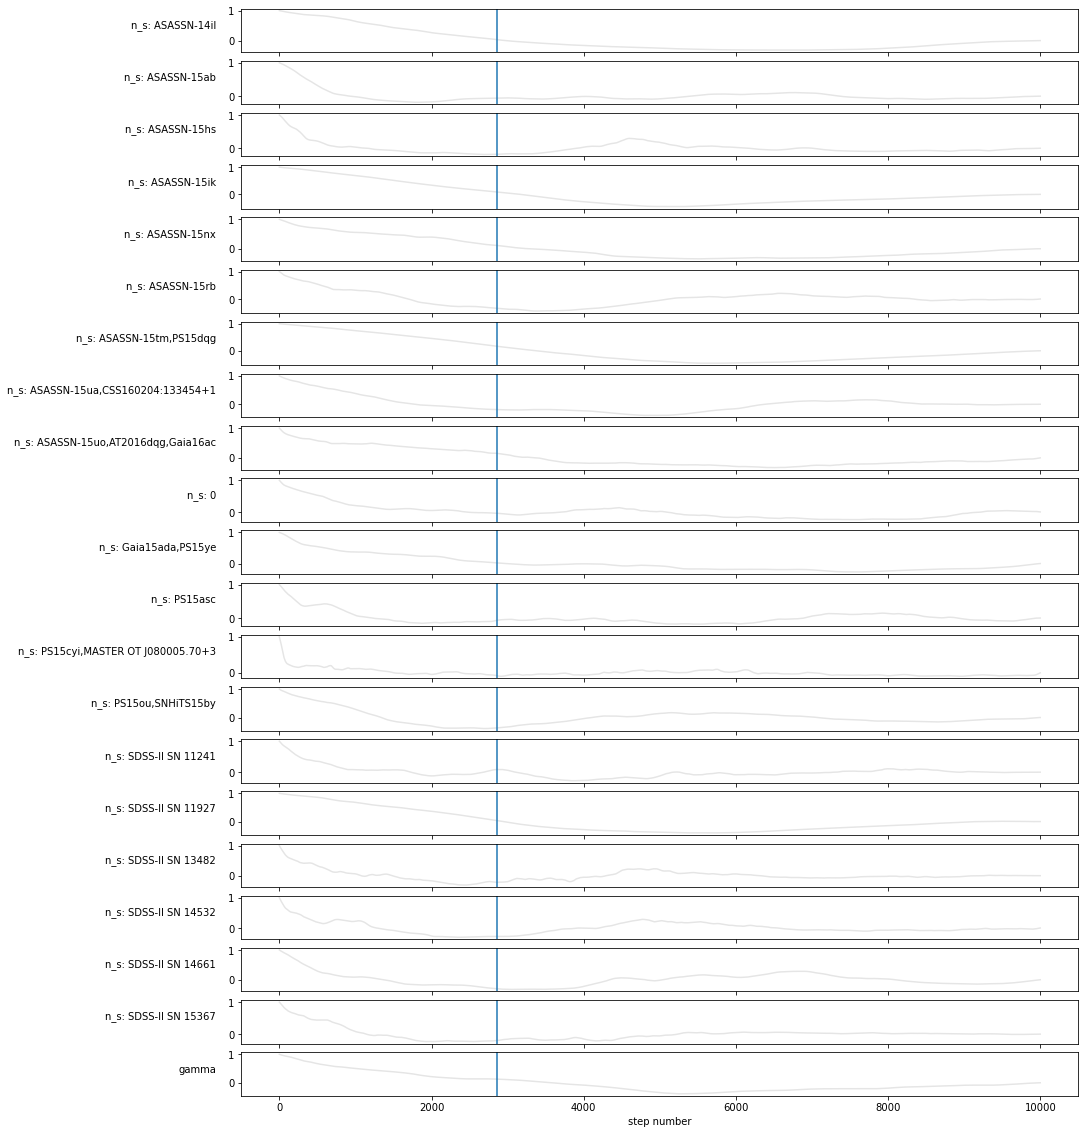

In [44]:
fig, axes = plt.subplots(ndim, figsize=(15, 20), sharex=True)
# samples = sampler.get_chain()
labels = corner_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(eac.function_1d(mcmc_pickle[:,0,i]), "k", alpha=0.1)
    ax.axvline(3 * eac.integrated_time(mcmc_pickle[:,0,:], quiet=True)[0], 0, 1)
#     ax.set_xlim(0, len(mcmc_pickle[:500]))
    ax.set_ylabel(labels[i], rotation=0, ha='right')
    ax.yaxis.set_label_coords(-0.03, 0.5)

axes[-1].set_xlabel("step number");

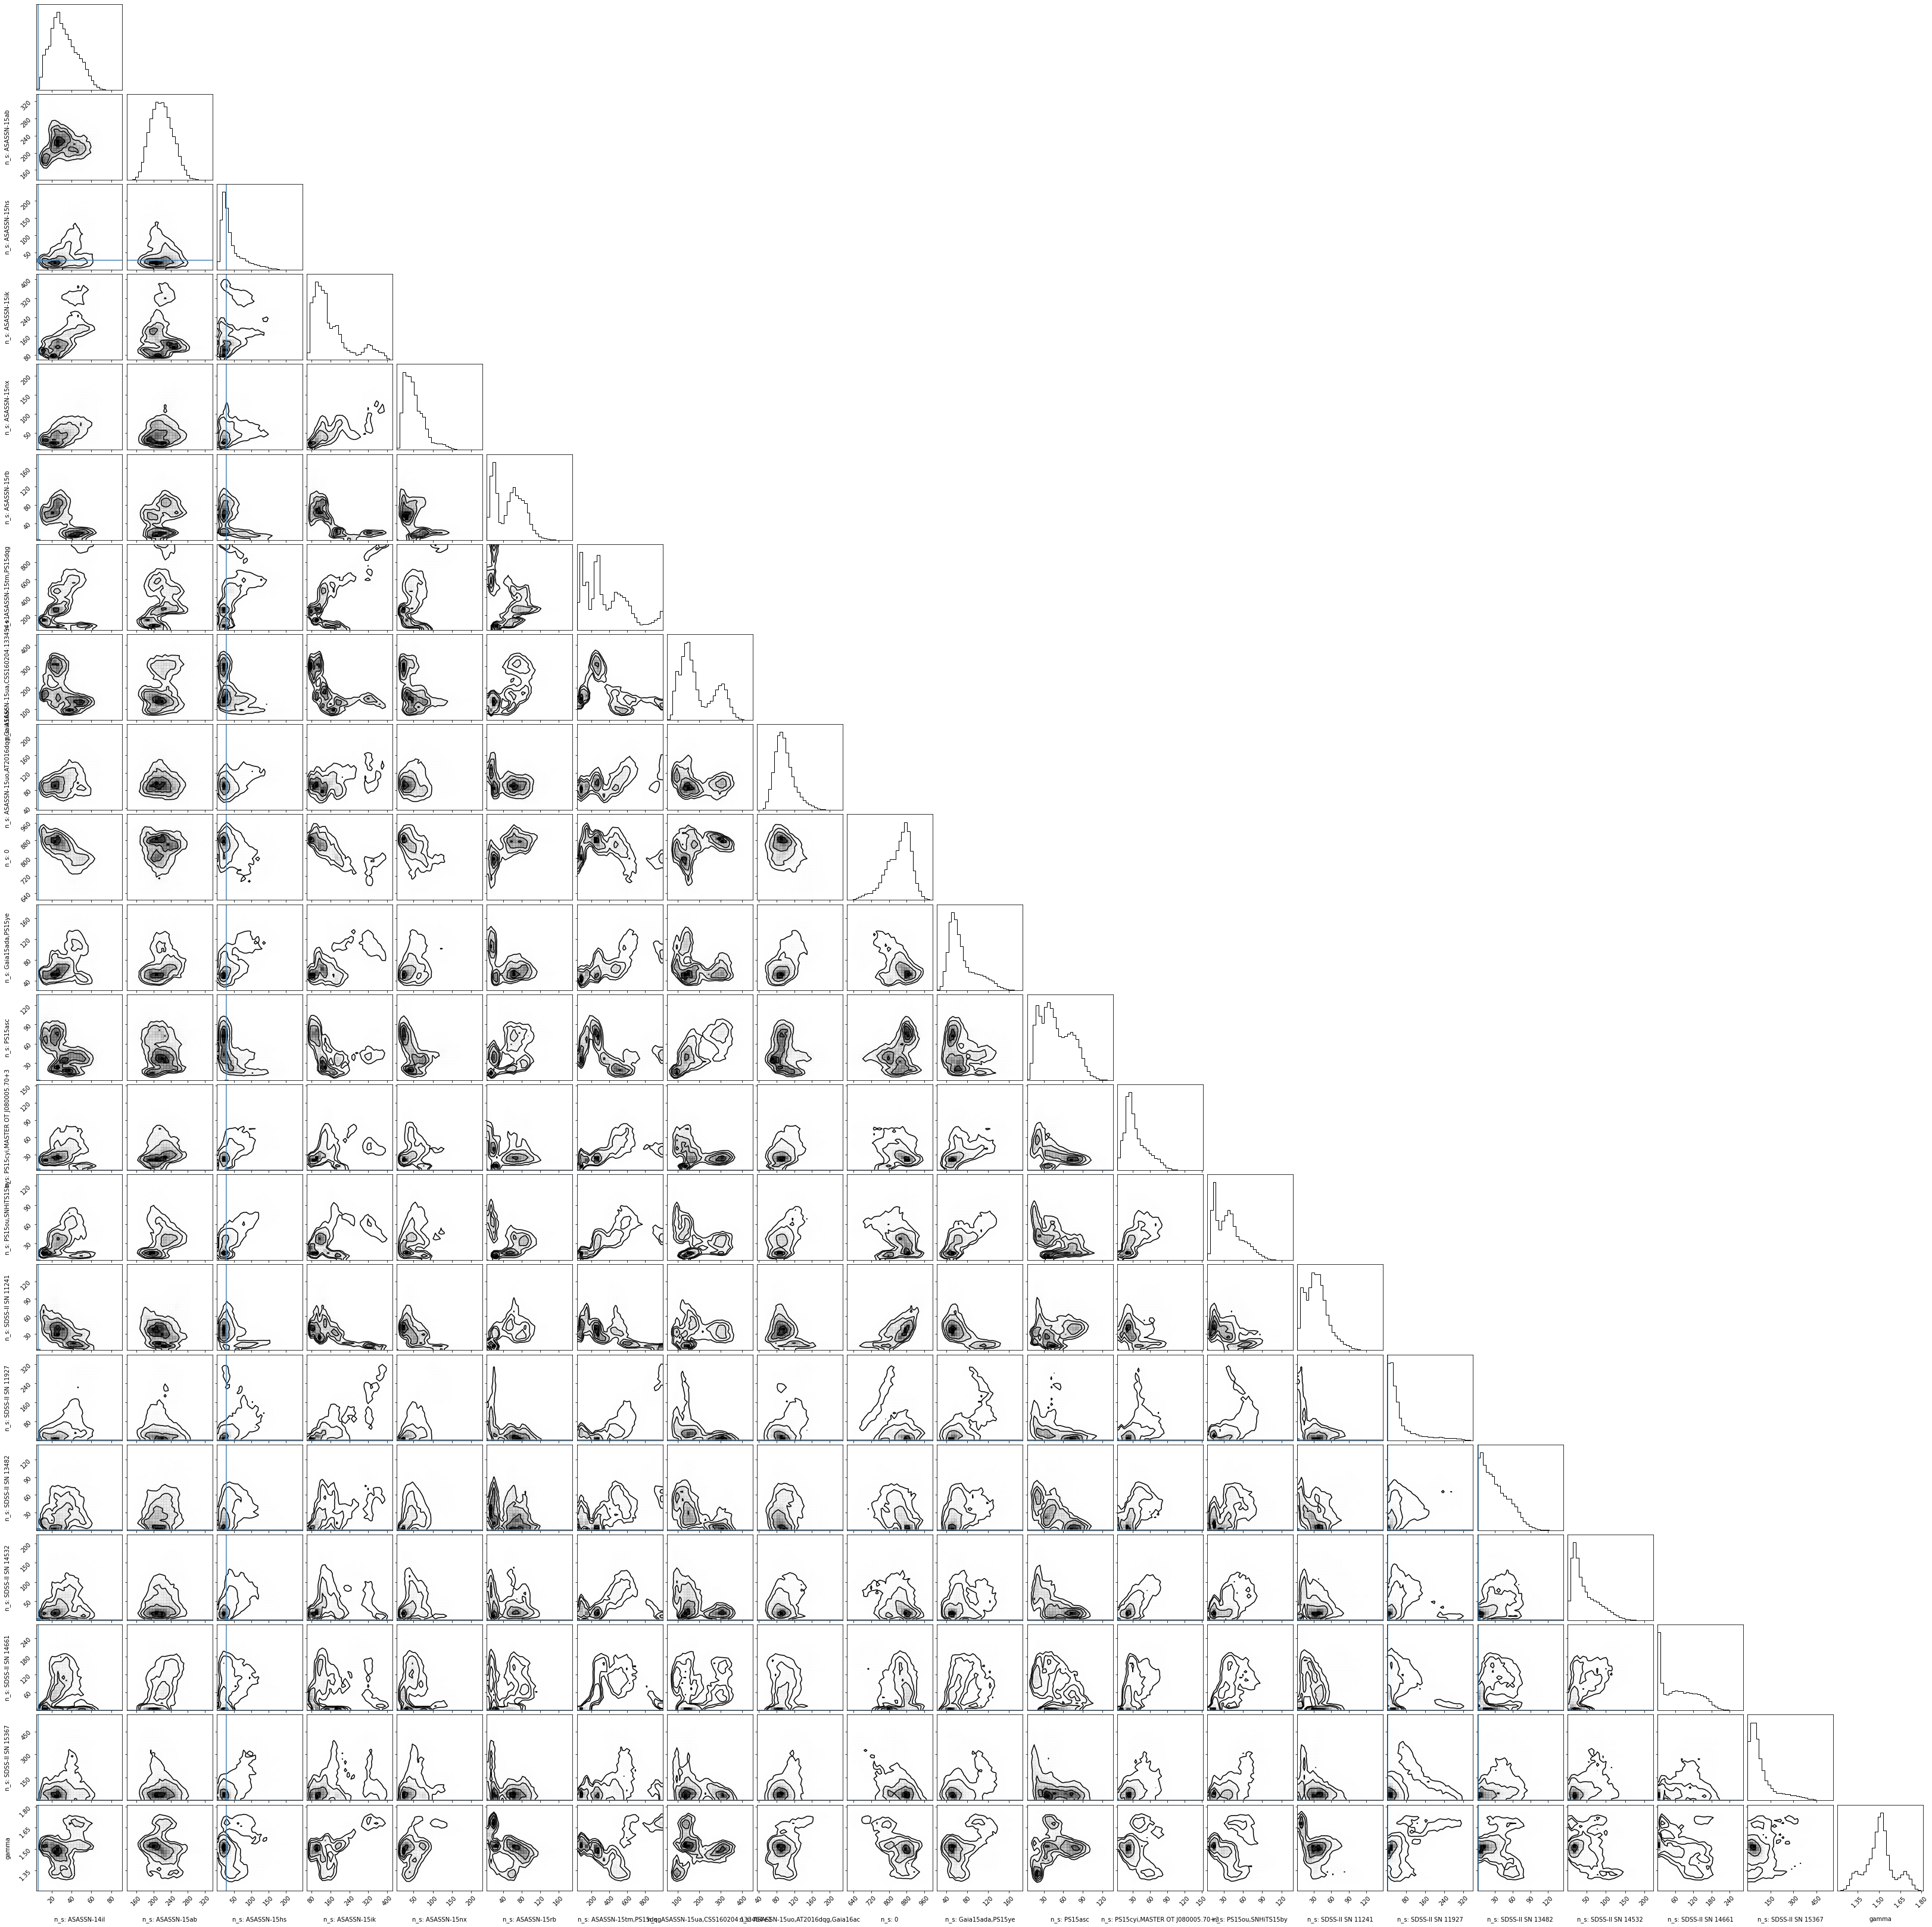

In [43]:
# Corner plots without burn in
n_burnin = 4000
no_burn = mcmc_pickle[n_burnin:].reshape((-1,ndim))

fig = corner.corner(no_burn,
                    labels=corner_labels,
#                     levels=[1-np.exp(-0.5*(x**2)) for x in range(1,4)],
#                     range=[[1100,1350], [50,200], [-20,20], [0.4,0.9], [1.7*np.pi,2*np.pi], [0.12,0.32], [0.5,1.5]],
                    truths = truths,
                    plot_datapoints=False,
                    bins=30)

# Save figure to output directory
plt.savefig(os.path.join(plot_output_dir(name), 'corner.png'))

In [35]:
for i in range(ndim):
    q_16, q_50, q_84 = corner.quantile(no_burn[:,i], [0.16, 0.5, 0.84]) # your x is q_50
    dx_down, dx_up = q_50-q_16, q_84-q_50
    print(f'{i:>3d} {corner_labels[i]:>40s} : {q_50:>7.2f} [{dx_down:<4.2f}, {dx_up:<4.2f}]')

  0                         n_s: ASASSN-14il :   43.76 [21.28, 120.07]
  1                         n_s: ASASSN-15ab :  210.01 [28.77, 33.72]
  2                         n_s: ASASSN-15hs :   26.76 [13.80, 41.27]
  3                         n_s: ASASSN-15ik :  211.04 [105.92, 156.52]
  4                         n_s: ASASSN-15nx :   72.16 [40.95, 146.90]
  5                         n_s: ASASSN-15rb :   44.49 [24.77, 36.61]
  6                 n_s: ASASSN-15tm,PS15dqg :  577.10 [396.56, 408.98]
  7      n_s: ASASSN-15ua,CSS160204:133454+1 :  141.66 [66.50, 139.50]
  8      n_s: ASASSN-15uo,AT2016dqg,Gaia16ac :  111.84 [29.45, 90.12]
  9                                   n_s: 0 :  829.86 [70.64, 53.19]
 10                    n_s: Gaia15ada,PS15ye :   75.60 [25.56, 97.92]
 11                             n_s: PS15asc :   52.55 [23.90, 25.30]
 12      n_s: PS15cyi,MASTER OT J080005.70+3 :   34.23 [14.17, 22.93]
 13                   n_s: PS15ou,SNHiTS15by :   32.66 [16.68, 25.77]
 14          

In [36]:
nsteps, nwalkers, nparams = mcmc_pickle.shape
acf = np.zeros(shape=(nsteps, nparams))
for i in range(nparams):
    temp = np.zeros(shape=(nsteps, nwalkers))
    for x in range(nwalkers):
        temp[:,x] = eac.function_1d(mcmc_pickle[:,x,i])
    acf[:,i] = temp.mean(axis=1)
    
acf

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.99329011e-01,  9.99046648e-01,  9.97917283e-01, ...,
         9.98020626e-01,  9.95214403e-01,  9.99004415e-01],
       [ 9.98702243e-01,  9.98131523e-01,  9.95940896e-01, ...,
         9.96158395e-01,  9.90784251e-01,  9.98049414e-01],
       ...,
       [ 3.64859612e-05, -2.03910579e-04, -2.03326793e-04, ...,
        -7.52592097e-04, -1.76562281e-04, -3.34788486e-04],
       [ 2.51975068e-05, -1.35976795e-04, -1.33738349e-04, ...,
        -5.04059803e-04, -1.17593048e-04, -2.21108921e-04],
       [ 1.31319482e-05, -6.80923531e-05, -6.59466493e-05, ...,
        -2.53677705e-04, -5.84023400e-05, -1.10131856e-04]])

N/50 = 200;
tau: [1299.74521616  442.71586385  429.72199009 1218.57708509 1301.72984901
  637.53499635 1346.52798562  813.23600899 1271.788218   1164.05851049
 1293.7571179   495.98190065  466.6066853   532.37587771  675.63979081
 1203.31442673  434.14834558  442.34251486  524.29425704  520.36731634
 1218.0880405 ]


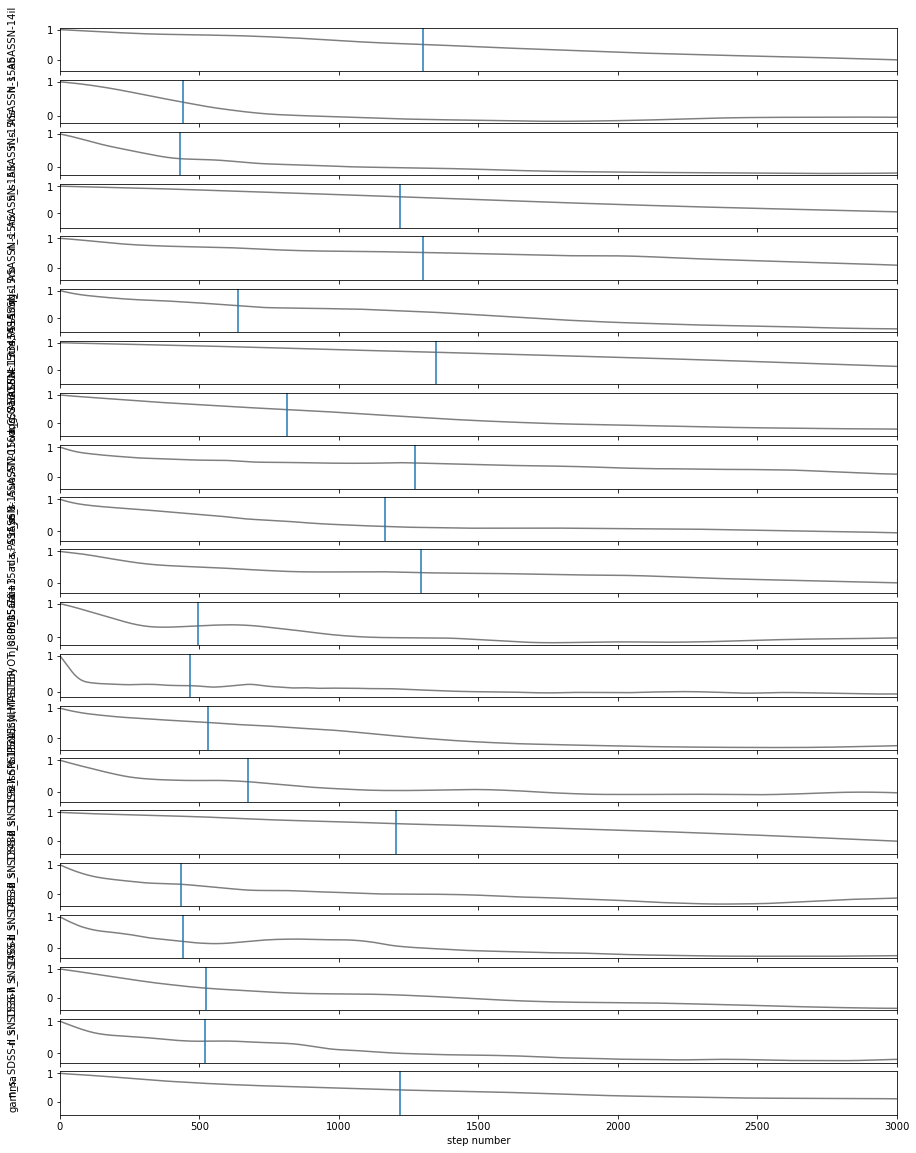

In [40]:
# First 500 steps
fig, axes = plt.subplots(ndim, figsize=(15, 20), sharex=True)
# samples = sampler.get_chain()
labels = corner_labels
act = eac.integrated_time(mcmc_pickle[:,:,:], quiet=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(acf[:,i], "k", alpha=0.5)
    ax.axvline(act[i], 0, 1)
    ax.set_xlim(0, len(mcmc_pickle[:3000]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

axes[-1].set_xlabel("step number");